In [ ]:
from google.colab import drive # Mount the google drive for data loading
drive.mount('/content/drive')

Mounted at /content/drive


# Import some related dependencies
1.   Numpy: a package for array transformation
2.   Matplotlib: a package for data visualization
3.   Tensorflow: a package for neural networks modeling
4.   Keras: a package for neural networks modeling which is established on Tensorflow
5.   Os: a package for processing files and directories

In [ ]:
import numpy as np #helps for array operation
import matplotlib.pyplot as plt #helps with graphical plots
import tensorflow as tf #helps for ANN model construction
import keras #helps for ANN model construction
import os #helps for create new file folder

# Test the GPU

In [ ]:
device_name = tf.test.gpu_device_name()  # Current GPU name 
if device_name != '/device:GPU:0':       # Test if the GPU exists
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name)) 

Found GPU at: /device:GPU:0


# Load data

In [13]:
style_url = "https://i.imgur.com/9ooB60I.jpg"                                                                             # Style image
style_image_path = tf.keras.utils.get_file(fname = "/content/drive/MyDrive/Wk_9/skyscraper.JPG", origin = style_url)  # Save style image to an absolute path

base_image_path = '/content/drive/MyDrive/Wk_9/9ooB60I.jpg'      # Absolute path of your customized base image 

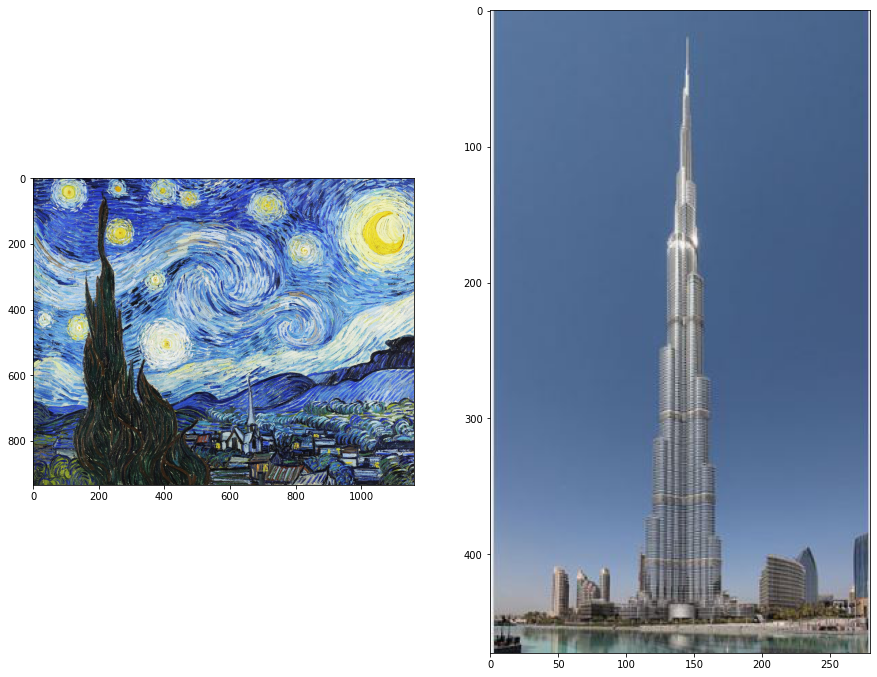

In [14]:
# Visualization of raw images
base_image = plt.imread(base_image_path)
style_image = plt.imread(style_image_path)
f, fig = plt.subplots(1,2, figsize=(15,15))
fig[0].imshow(base_image)
fig[1].imshow(style_image)
plt.show()

In [15]:
def preprocess_image(image_path, img_nrows, img_ncols):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))     # Resize the image to img_nrows x img_ncols
    img = keras.preprocessing.image.img_to_array(img)                                            # Convert the image to an array
    img = np.expand_dims(img, axis=0)                                                            # Convert the image array to a sample for next preprocessing step
    img = tf.keras.applications.vgg19.preprocess_input(img)                                      # The image is converted from RGB to BGR and subtracted by [103.939, 116.779, 123.68], which is a mean for BGR channels in Imagenet. Then, each color channel is zero-centered with respect to the ImageNet dataset, without scaling
    return tf.convert_to_tensor(img)                                                             # Convert the image to a tensor
    
def deprocess_image(x):
    '''Helps for image recovery'''
    x = x.reshape((img_nrows, img_ncols, 3))                                                     # Reshape the image
    x[:, :, 0] += 103.939                                                                        # The image is added by [103.939, 116.779, 123.68] for BGR channels, respectively
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]                                                                            # Convert the BGR image to RGB image
    x = np.clip(x, 0, 255).astype("uint8")                                                       # Convert the float array to int array [0, 255]
    return x

In [16]:
width, height = keras.preprocessing.image.load_img(base_image_path).size                  # Raw image with a shape of 1920x1200
img_nrows = 400                                                                           # New image height: 400
img_ncols = int(width * img_nrows / height)                                               # New image width: 640

base_image = preprocess_image(base_image_path, img_nrows, img_ncols)                      # New base image tensor after preprocessing
style_image = preprocess_image(style_image_path, img_nrows, img_ncols)                    # New style image tensor after preprocessing
combination_image = tf.Variable(preprocess_image(base_image_path, img_nrows, img_ncols))  # New combination image tensor after preprocessing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


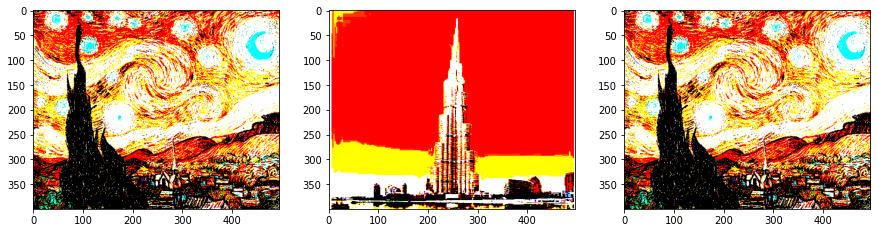

In [17]:
# Visualization of proprecessed images
f, fig = plt.subplots(1, 3, figsize=(15,15))
fig[0].imshow(base_image[0])                 # base_image[0]: convert a sample to an image array 
fig[1].imshow(style_image[0])                
fig[2].imshow(combination_image[0])
plt.show()

# Define loss funtion
1. Style loss
2. Content loss

In [18]:
# Calculation of Gram Matrix in style loss
def gram_matrix(x):   
    x = tf.transpose(x, (2, 0, 1))                       # Data is converted to Channel x width x height
    features = tf.reshape(x, (tf.shape(x)[0], -1))       # Data is converted to Channel x (width x height)
    gram = tf.matmul(features, tf.transpose(features))   # Gram Matrix with a shape of Channel x Channel 
    return gram

In [19]:
# Define style loss
def style_loss(style, combination):
    S = gram_matrix(style)                               # Gram Matrix for the style image: 3x3
    C = gram_matrix(combination)                         # Gram Matrix for the combination image: 3x3
    channels = 3                                         # RGB channels
    size = img_nrows * img_ncols                         
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [20]:
# Define content loss
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

# Load the VGG19 model

In [21]:
model = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)   # The model weights are based on the ImageNet
model.summary()

outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)         # Feature extracter for all layers in VGG19

80150528/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

# Calculate the loss using VGG19

In [22]:
layer_style = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]  # Layers for style loss calculation 
layer_content = "block5_conv2"                                                                  # Layers for content loss calculation 

content_weight = 2.5e-8                                                                         # Weights for content loss
style_weight = 1e-6                                                                             # Weights for style loss                                                           

def loss_function(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)    # Combine all the images in a same tensor
    features = feature_extractor(input_tensor)                                                  # Get the values in all the layers for the three images
    loss = tf.zeros(shape=())                                                                   # Initialize the loss                                           

    layer_features = features[layer_content]                                                    # Extract the features for content loss
    base_image_features = layer_features[0, :, :, :]                                            # Features of base image
    combination_features = layer_features[2, :, :, :]                                           # Features of combination image

    loss = loss + content_weight * content_loss(base_image_features, combination_features)      # Content loss

    for layer_name in layer_style:                                                              # Extract the features in each layer to calculate style loss
        layer_features = features[layer_name]                                                   # Features of three images to calculate style loss in each layer 
        style_reference_features = layer_features[1, :, :, :]                                   # Features of style image 
        combination_features = layer_features[2, :, :, :]                                       # Features of combination image 
        sl = style_loss(style_reference_features, combination_features)                         # Style loss between combination image and style image 
        loss += (style_weight / len(layer_style)) * sl                                          # Add style loss 
    return loss

def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    '''Helps for calculate the model loss and gradients of weights'''
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [23]:
def create_dir(path):
  folder = os.path.exists(path)
  if not folder:
    os.makedirs(path)
  return path
new_path = create_dir('/content/drive/MyDrive/lab_code/image_generate1/')  # Create a new file folder for saving generated images
print(new_path)

/content/drive/MyDrive/lab_code/image_generate1/


In [24]:
def result_saver(iteration):
  image_name = new_path +str(iteration) + "_image" + '.png'       # Saved image name
  img = deprocess_image(combination_image.numpy())                                                         # Image recovery
  keras.preprocessing.image.save_img(image_name, img)                                                      # Save image

In [25]:
optimizer = tf.keras.optimizers.SGD(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))
iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_image)      # Compute model loss and gradients
    optimizer.apply_gradients([(grads, combination_image)])                               # Update model weights
    if i % 10 == 0:                                                                       # Save the combination image per 10 epochs
        print("Iteration %d: loss=%.2f" % (i, loss))
        result_saver(i)

Iteration 10: loss=24119.99
Iteration 20: loss=14020.92
Iteration 30: loss=9808.97
Iteration 40: loss=7466.91
Iteration 50: loss=5988.81
Iteration 60: loss=4983.90
Iteration 70: loss=4260.69
Iteration 80: loss=3716.35
Iteration 90: loss=3294.62
Iteration 100: loss=2958.82
Iteration 110: loss=2685.41
Iteration 120: loss=2458.70
Iteration 130: loss=2268.13
Iteration 140: loss=2104.88
Iteration 150: loss=1963.39
Iteration 160: loss=1839.70
Iteration 170: loss=1730.40
Iteration 180: loss=1633.47
Iteration 190: loss=1546.89
Iteration 200: loss=1468.97
Iteration 210: loss=1398.64
Iteration 220: loss=1335.07
Iteration 230: loss=1277.31
Iteration 240: loss=1224.49
Iteration 250: loss=1175.89
Iteration 260: loss=1131.02
Iteration 270: loss=1089.55
Iteration 280: loss=1051.46
Iteration 290: loss=1016.22
Iteration 300: loss=983.41
Iteration 310: loss=952.91
Iteration 320: loss=924.46
Iteration 330: loss=898.01
Iteration 340: loss=873.23
Iteration 350: loss=849.95
Iteration 360: loss=828.04
Iterat

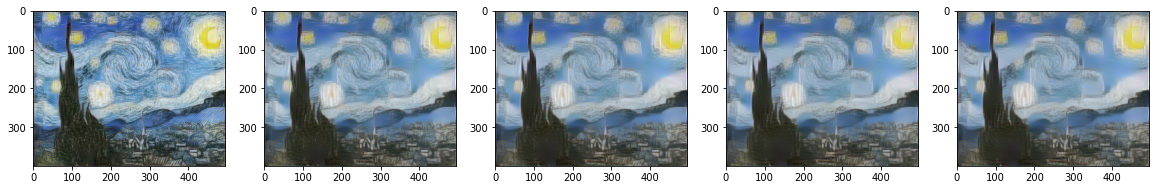

In [26]:
# Visualization of generated images
generated_image_100 = plt.imread("/content/drive/MyDrive/lab_code/image_generate1/100_image.png")   # Generated image on the 100th epoch
generated_image_1000 = plt.imread("/content/drive/MyDrive/lab_code/image_generate1/1000_image.png") # Generated image on the 1000th epoch
generated_image_2000 = plt.imread("/content/drive/MyDrive/lab_code/image_generate1/2000_image.png") # Generated image on the 2000th epoch
generated_image_3000 = plt.imread("/content/drive/MyDrive/lab_code/image_generate1/3000_image.png") # Generated image on the 3000th epoch
generated_image_4000 = plt.imread("/content/drive/MyDrive/lab_code/image_generate1/4000_image.png") # Generated image on the 4000th epoch
f, fig = plt.subplots(1,5, figsize=(20,20))
fig[0].imshow(generated_image_100)
fig[1].imshow(generated_image_1000)
fig[2].imshow(generated_image_2000)
fig[3].imshow(generated_image_3000)
fig[4].imshow(generated_image_4000)
plt.show()